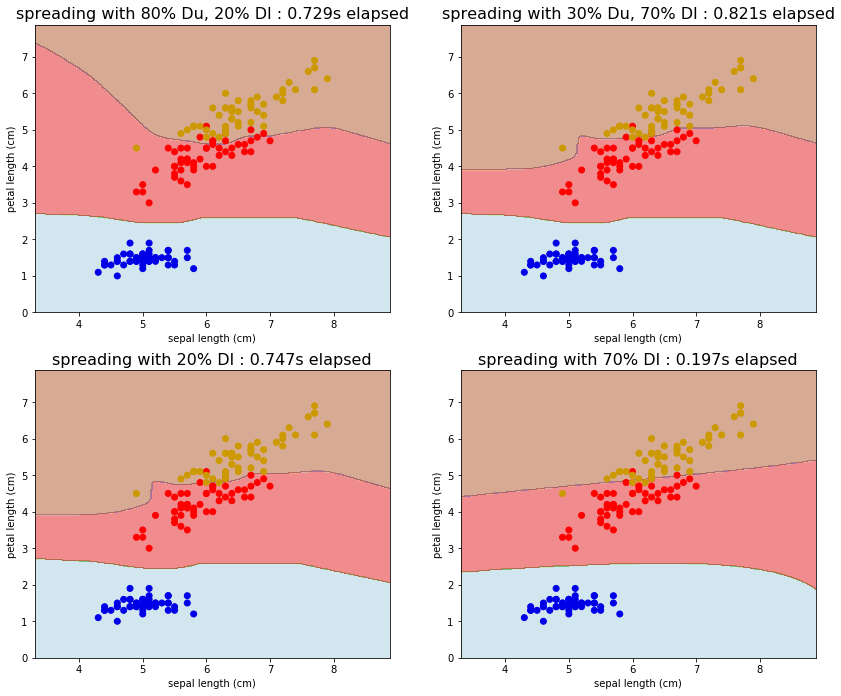

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.semi_supervised import label_propagation
import time
from sklearn import metrics

rng = np.random.RandomState(0)

iris = datasets.load_iris()

X = iris.data[:, [0,2]]
y = iris.target

y_30 = np.copy(y)
y_30[rng.rand(len(y)) < 0.3] = -1
y_80 = np.copy(y)
y_80[rng.rand(len(y)) < 0.8] = -1
# create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
lu80 = (label_propagation.LabelSpreading().fit(X, y_80), X, y_80)
lu30 = (label_propagation.LabelSpreading().fit(X, y_30), X, y_30)
l20 = (label_propagation.LabelSpreading().fit(X[y_80 != -1], y_80[y_80 != -1]), X[y_80 != -1], y_80[y_80 != -1])
l70 = (label_propagation.LabelSpreading().fit(X[y_30 != -1], y_30[y_30 != -1]), X[y_30 != -1], y_30[y_30 != -1])
l100 = (label_propagation.LabelSpreading().fit(X, y), X, y)
rbf_svc = (svm.SVC().fit(X, y), X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

titles = [ 'spreading with 80% Du, 20% Dl', 'spreading with 30% Du, 70% Dl',
          'spreading with 20% Dl', 'spreading with 70% Dl', 
          'spreading with 100% Dl',  'SVC with RBF kernel']
color_map = {-1: (.5, .5, .5), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.8, .6, 0)}
fig = plt.figure(figsize=(14,18))
y_traina = []
for i, (clf, x, y_train) in enumerate((lu80, lu30, l20, l70, l100)):
    y_traina = y_train
for i, (clf, x, y_train) in enumerate((lu80, l100,  l100, rbf_svc)):
    start = time.time()
    ax = fig.add_subplot(3, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #print(metrics.adjusted_rand_score(y_train, Z))
    
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.Paired,alpha=.5)

    colors = [color_map[y] for y in y_traina]
    
    ax.scatter(x[:, 0], x[:, 1], c=colors, cmap=plt.cm.Paired)
    end = time.time()
    ax.set_title('{0} : {1:.3f}s elapsed'.format(titles[i], end-start), fontsize=16)
    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[2])
plt.show()
fig.savefig('tu.png',dpi=200)

In [12]:
# -*- coding: utf-8 -*-
import numpy as np

def distEclud(vecA, vecB):
    '''
    输入：向量A和B
    输出：A和B间的欧式距离
    '''
    return np.sqrt(sum(np.power(vecA - vecB, 2)))
 
def newCent(L):
    '''
    输入：有标签数据集L
    输出：根据L确定初始聚类中心
    '''
    centroids = []
    label_list = np.unique(L[:,-1])
    for i in label_list:
        L_i = L[(L[:,-1])==i]
        cent_i = np.mean(L_i,0)
        centroids.append(cent_i[:-1])
    return np.array(centroids) 

def semi_kMeans(L, U, distMeas=distEclud, initial_centriod=newCent):
    '''
    输入：有标签数据集L（最后一列为类别标签）、无标签数据集U（无类别标签）
    输出：聚类结果
    '''
    dataSet = np.vstack((L[:,:-1],U))#合并L和U
    label_list = np.unique(L[:,-1])
    k = len(label_list)
    print(k)#L中类别个数
    m = np.shape(dataSet)[0]
    
    clusterAssment = np.zeros(m)#初始化样本的分配                             
    centroids = initial_centriod(L)#确定初始聚类中心
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#将每个样本分配给最近的聚类中心
            minDist = np.inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i] != minIndex: clusterChanged = True
            clusterAssment[i] = minIndex
            
        for cent in range(k):
            #得到属于第cent个簇的样本的集合
            ptsInClust = dataSet[np.nonzero(clusterAssment==cent)[0]] 
            #计算这个集合里面样本的均值，即中心
            centroids[cent,:] = np.mean(ptsInClust, axis=0) 

    return clusterAssment  
    
L =np.array([[1.0, 4.2 ,2],
    [1.3, 4.0 , 1],
    [1.0, 4.0 , 1],
    [1.5, 4.3 , 1],
    [2.0, 4.0 , 0],
    [2.3, 3.7 , 0],
    [4.0, 1.0 , 0]])
 #L的最后一列是类别标签   
U =np.array([[1.4, 5.0],
    [1.3, 5.4],
    [2.0, 5.0],
    [4.0, 2.0],
    [5.0, 1.0],
    [5.0, 2.0]])

clusterResult = semi_kMeans(L,U)



3


In [13]:
print(clusterResult)

[2. 1. 2. 1. 1. 1. 0. 2. 2. 1. 0. 0. 0.]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1]
0.7570029149464148


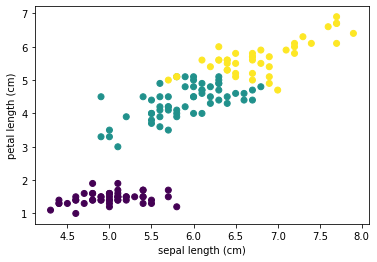

In [67]:
from collections import defaultdict
from math import sqrt
import pandas as pd
# 使用ARI进行K-means聚类性能评估
from sklearn import metrics
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# 0:0 1 8 15 26
# 1:11 24 28 35 4
# 2:5 25 37 41 48
# 3:14 47 59 71 73
# 4:3 16 19 39 46
# 5:6 7 13 22 65
# 6:4 27 33 45 54
# 7:2 10 17 20 30
# 8:9 18 21 29 49
# 9:12 23 34 36 38

# 读取文件
def readdata():
    dataset = []
    with open('lris2.txt', 'r') as file:
        for line in file:
            if line == '\n':
                continue
            # map()是 Python 内置的高阶函数，它接收一个函数 f 和一个 list，
            # 并通过把函数 f 依次作用在 list 的每个元素上，得到一个新的 list 并返回。
            dataset.append(list(map(float, line.split(',')[:-1])))
        file.close()
        return dataset


# 读取种子集（有标签数据）
def readseed(dataset, label):
    seedset = defaultdict(list)
    for i in range(3):
        for j in range(len(label[0])):
            seedset[i].append(dataset[label[i][j]])
    return seedset



# 输入：每一类的数据
# 输出：这一类新的质心
# 方法：求出这一类数据的总和求平均值
def point_avg(points):
    dimensions = len(points[0])
    new_center = []
    for dimension in range(dimensions):
        sum = 0
        # 求出每一列的数据总和
        for p in points:
            sum += p[dimension]
        new_center.append(float("%.8f" % (sum / float(len(points)))))
    return new_center


# 输入：数据集，质心数据，质心数量
# 输出：新的质心数据
# 功能：更新质心数据
def update_centers(data_set, assignments, k):
    # new_means，记录前一次学习的标签结果
    new_means = defaultdict(list)
    centers = []
    for assignment, point in zip(assignments, data_set):
        new_means[assignment].append(point)
    for i in range(k):
        # 逐一对每一类进行质心更新
        points = new_means[i]
        centers.append(point_avg(points))
    return centers


# 输入：数据集，质心
# 输出：数组，每一个单元代表对应数据的类别。如assignment[0]=0，代表第0个数据的类别是第0类
# 功能：求数据集每个单元数据的标签
def assign_points(data_points, centers, label):
    assignments = []
    index = 0
    for point in data_points:
        flag = 1
        # 有标签数据，直接填写对应标签
        for k in range(len(label)):
            if index in label[k]:
                index = index+1
                assignments.append(k)
                flag = 0
                break
        if flag == 0:
            continue
        # 无标签数据求类别
        # float('inf')表示正无穷
        shortest = float('inf')
        shortest_index = 0
        # 取距离最近的质心的下标
        for i in range(len(centers)):
            value = distance(point, centers[i])
            if value < shortest:
                shortest = value
                shortest_index = i
        assignments.append(shortest_index)
        index = index+1
    return assignments


# 求欧拉距离
def distance(a, b):
    dimention = len(a)
    sum = 0
    for i in range(dimention):
        sq = (a[i] - b[i]) ** 2
        sum += sq
    return sqrt(sum)


# 输入：数据集，质心个数
# 输出：质心数据
# 功能：用随机数的方法生成初始质心
def generate_k(seedset, k):
    centers = []
    for i in range(k):
        point = seedset[i]
        centers.append(point_avg(point))
    return centers

def k_means(dataset, seedset, k, Y_train, label):
    # 求初始质心
    k_points = generate_k(seedset, k)
    # 求标签
    assignments = assign_points(dataset, k_points, label)
    old_assignments = None

    # 直到标签没变，停止
    while assignments != old_assignments:
        # 更新质心数据
        new_centers = update_centers(dataset, assignments, k)
        old_assignments = assignments
        # 更新标签
        assignments = assign_points(dataset, new_centers, label)

    # 输出准确率
    print(assignments)
    precision_rate = metrics.adjusted_rand_score(Y_train, assignments)
    print(precision_rate)
    lris_df = datasets.load_iris()
 
    #挑选出前两个维度作为x轴和y轴，你也可以选择其他维度
    x_axis = lris_df.data[:,0]
    y_axis = lris_df.data[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[2])
    plt.scatter(x_axis, y_axis, c=assignments)
    plt.show()
    fig.savefig('kmean2.png',dpi=100)
    


def main():
    # 标签集
    label = [[0, 10, 2,9,6,11,12,34],
             [70, 66, 62, 83,94,56,67,88],
             [131, 142, 103, 124, 115,112,113,144]]
    dataset = readdata()
    seedset = readseed(dataset, label)
    # 使用pandas分别读取训练数据与测试数据
    digits_train = pd.read_csv('lris2.txt', header=None)
    digits_train.shape
    Y_train = digits_train[4]
    k_means(dataset, seedset, 3, Y_train, label)


if __name__ == "__main__":
    main()


In [41]:
digits_train = pd.read_csv('lris2.txt', header=None)
digits_train.shape

(150, 1)

In [19]:
a = readdata()
len(a[0])

64

In [20]:
digits_train = pd.read_csv('test_port.txt', header=None)
Y_train = digits_train[64]
#Y_train
digits_train.shape

(310, 65)

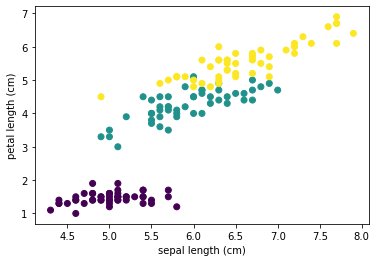

In [68]:
from sklearn import datasets
import matplotlib.pyplot as plt
 
#加载数据集，是一个字典类似Java中的map
lris_df = datasets.load_iris()
 
 
#挑选出前两个维度作为x轴和y轴，你也可以选择其他维度
x_axis = lris_df.data[:,0]
y_axis = lris_df.data[:,2]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[2])
#c指定点的颜色，当c赋值为数值时，会根据值的不同自动着色
plt.scatter(x_axis, y_axis, c=lris_df.target)
plt.show()
fig.savefig('original.png',dpi=100)

0.7302382722834697


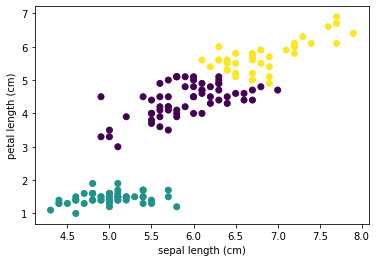

In [13]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
#加载数据集，是一个字典类似Java中的map
lris_df = datasets.load_iris()
 
#挑选出前两个维度作为x轴和y轴，你也可以选择其他维度
x_axis = lris_df.data[:,0]
y_axis = lris_df.data[:,2]
 
 
#这里已经知道了分3类，其他分类这里的参数需要调试
model = KMeans(n_clusters=3)
 
#训练模型
model.fit(lris_df.data)
 
#选取行标为100的那条数据，进行预测
prddicted_label= model.predict([[6.3, 3.3, 6, 2.5]])
 
#预测全部150条数据
all_predictions = model.predict(lris_df.data)
 
#打印出来对150条数据的聚类散点图
precision_rate = metrics.adjusted_rand_score(lris_df.target, all_predictions)
print(precision_rate)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(lris_df.feature_names[0])
ax.set_ylabel(lris_df.feature_names[2])
plt.scatter(x_axis, y_axis, c=all_predictions)
plt.show()
fig.savefig('kmeans.png',dpi=100)

In [98]:
#encoding utf-8
# time: 2018/08/09
# name: py粉
import numpy as np
from sklearn import datasets
iris=datasets.load_iris()
#print(iris)
#标签
labels=np.copy(iris.target)
#print(labels)
#随机选一些，标签设置为（0-1之间）
random_unlabels_points=np.random.rand(len(iris.target))
#print(random_unlabels_points)
#小于0.3的为True即为1，大于0.3的数为False
random_unlabels_points=random_unlabels_points<0.8
#print(random_unlabels_points)
#把True（为1）随机抽取的的标签的值换为-1
Y=labels[random_unlabels_points]
#print(Y)
labels[random_unlabels_points]=-1
#print(iris.target)
#print(labels)
print("Unlabels Number",list(labels).count(-1))

from sklearn.semi_supervised import LabelPropagation
label_prop_model=LabelPropagation()
label_prop_model.fit(iris.data,labels)
Y_pred=label_prop_model.predict(iris.data)
Y_pred=Y_pred[random_unlabels_points]
from sklearn.metrics import accuracy_score,recall_score,f1_score

print("ACC",accuracy_score(Y,Y_pred))
print("REC",recall_score(Y,Y_pred,average="micro"))
print("F-score",f1_score(Y,Y_pred,average="micro"))


Unlabels Number 121
ACC 0.9669421487603306
REC 0.9669421487603306
F-score 0.9669421487603306
